# 2022_01_27 
2,000 epochs 1,000 data
https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/conv_lstm.ipynb

# Next-Frame Video Prediction with Convolutional LSTMs

Author: Amogh Joshi
Date created: 2021/06/02
Last modified: 2021/06/05
Description: How to build and train a convolutional LSTM model for next-frame video prediction.
Introduction

The Convolutional LSTM architectures bring together time series processing and computer vision by introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the Convolutional LSTM model in an application to next-frame prediction, the process of predicting what video frames come next given a series of past frames.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

# Dataset Construction

For this example, we will be using the Moving MNIST dataset.

We will download the dataset and then construct and preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame, which we'll call f_n, to predict a new frame, called f_(n + 1). To allow the model to create these predictions, we'll need to process the data such that we have "shifted" inputs and outputs, where the input data is frame x_n, being used to predict frame y_(n + 1).


In [2]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


# Data Visualization

Our data consists of sequences of frames, each of which are used to predict the upcoming frame. Let's take a look at some of these sequential frames.


Displaying frames for example 40.


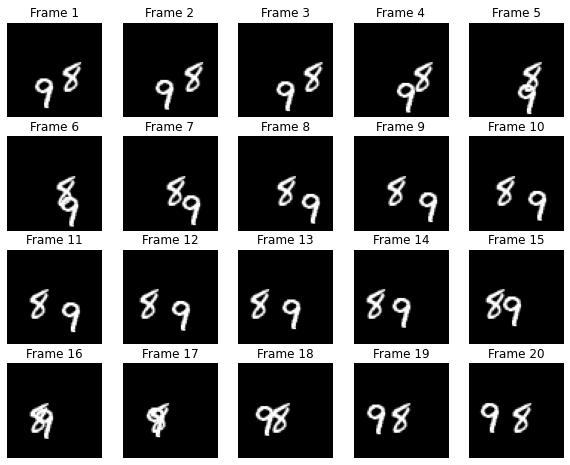

In [3]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

# Model Construction

To build a Convolutional LSTM model, we will use the ConvLSTM2D layer, which will accept inputs of shape (batch_size, num_frames, width, height, channels), and return a prediction movie of the same shape.


In [4]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

# Model Training

With our model and data constructed, we can now train the model.


In [5]:
# Define some callbacks to improve training.
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=200)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=50)

# Define modifiable training hyperparameters.
epochs = 2000
batch_size = 5

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[model_checkpoint_callback],
)

Epoch 1/2000
180/180 [==============================] - 124s 636ms/step - loss: 0.0591 - val_loss: 0.2233
Epoch 2/2000
180/180 [==============================] - 113s 628ms/step - loss: 0.0277 - val_loss: 0.2504
Epoch 3/2000
180/180 [==============================] - 114s 633ms/step - loss: 0.0265 - val_loss: 0.0728
Epoch 4/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.0259 - val_loss: 0.0295
Epoch 5/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.0255 - val_loss: 0.0254
Epoch 6/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.0253 - val_loss: 0.0251
Epoch 7/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.0249 - val_loss: 0.0249
Epoch 8/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.0247 - val_loss: 0.0247
Epoch 9/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.0246 - val_loss: 0.0246
Epoch 10/2000
180/180 [=======================

180/180 [==============================] - 117s 653ms/step - loss: 0.0232 - val_loss: 0.0241
Epoch 45/2000
180/180 [==============================] - 118s 653ms/step - loss: 0.0231 - val_loss: 0.0240
Epoch 46/2000
180/180 [==============================] - 118s 653ms/step - loss: 0.0231 - val_loss: 0.0241
Epoch 47/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.0231 - val_loss: 0.0241
Epoch 48/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0230 - val_loss: 0.0243
Epoch 49/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0230 - val_loss: 0.0241
Epoch 50/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0229 - val_loss: 0.0242
Epoch 51/2000
180/180 [==============================] - 118s 653ms/step - loss: 0.0229 - val_loss: 0.0241
Epoch 52/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.0229 - val_loss: 0.0241
Epoch 53/2000
180/180 [============================

180/180 [==============================] - 121s 670ms/step - loss: 0.0218 - val_loss: 0.0255
Epoch 88/2000
180/180 [==============================] - 119s 663ms/step - loss: 0.0218 - val_loss: 0.0255
Epoch 89/2000
180/180 [==============================] - 118s 656ms/step - loss: 0.0218 - val_loss: 0.0254
Epoch 90/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.0218 - val_loss: 0.0255
Epoch 91/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.0218 - val_loss: 0.0254
Epoch 92/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0218 - val_loss: 0.0255
Epoch 93/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0218 - val_loss: 0.0254
Epoch 94/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.0217 - val_loss: 0.0256
Epoch 95/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.0217 - val_loss: 0.0254
Epoch 96/2000
180/180 [============================

180/180 [==============================] - 118s 654ms/step - loss: 0.0217 - val_loss: 0.0257
Epoch 131/2000
180/180 [==============================] - 118s 653ms/step - loss: 0.0221 - val_loss: 0.0255
Epoch 132/2000
180/180 [==============================] - 118s 653ms/step - loss: 0.0217 - val_loss: 0.0256
Epoch 133/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0216 - val_loss: 0.0256
Epoch 134/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0215 - val_loss: 0.0258
Epoch 135/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.0215 - val_loss: 0.0259
Epoch 136/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0215 - val_loss: 0.0258
Epoch 137/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0215 - val_loss: 0.0257
Epoch 138/2000
180/180 [==============================] - 119s 661ms/step - loss: 0.0215 - val_loss: 0.0257
Epoch 139/2000
180/180 [===================

Epoch 173/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.0215 - val_loss: 0.0257
Epoch 174/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.0215 - val_loss: 0.0259
Epoch 175/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.0215 - val_loss: 0.0257
Epoch 176/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.0215 - val_loss: 0.0261
Epoch 177/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.0215 - val_loss: 0.0259
Epoch 178/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.0215 - val_loss: 0.0259
Epoch 179/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.0215 - val_loss: 0.0258
Epoch 180/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 181/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.0214 - val_loss: 0.0257
Epoch 182/2000
180/180 [====

Epoch 216/2000
180/180 [==============================] - 114s 633ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 217/2000
180/180 [==============================] - 114s 632ms/step - loss: 0.0214 - val_loss: 0.0257
Epoch 218/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 219/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.0214 - val_loss: 0.0258
Epoch 220/2000
180/180 [==============================] - 114s 632ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 221/2000
180/180 [==============================] - 114s 632ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 222/2000
180/180 [==============================] - 114s 631ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 223/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 224/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 225/2000
180/180 [====

Epoch 259/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 260/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 261/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 262/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 263/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.0214 - val_loss: 0.0258
Epoch 264/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 265/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 266/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.0214 - val_loss: 0.0258
Epoch 267/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 268/2000
180/180 [====

Epoch 302/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 303/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 304/2000
180/180 [==============================] - 117s 653ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 305/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 306/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 307/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.0214 - val_loss: 0.0258
Epoch 308/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.0214 - val_loss: 0.0259
Epoch 309/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 310/2000
180/180 [==============================] - 118s 658ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 311/2000
180/180 [====

Epoch 345/2000
180/180 [==============================] - 118s 656ms/step - loss: 0.0213 - val_loss: 0.0259
Epoch 346/2000
180/180 [==============================] - 118s 657ms/step - loss: 0.0213 - val_loss: 0.0260
Epoch 347/2000
180/180 [==============================] - 118s 656ms/step - loss: 0.0216 - val_loss: 0.0258
Epoch 348/2000
180/180 [==============================] - 118s 658ms/step - loss: 0.0215 - val_loss: 0.0256
Epoch 349/2000
180/180 [==============================] - 118s 656ms/step - loss: 0.0214 - val_loss: 0.0260
Epoch 350/2000
180/180 [==============================] - 118s 657ms/step - loss: 0.0213 - val_loss: 0.0259
Epoch 351/2000
180/180 [==============================] - 118s 657ms/step - loss: 0.0213 - val_loss: 0.0260
Epoch 352/2000
180/180 [==============================] - 118s 656ms/step - loss: 0.0213 - val_loss: 0.0260
Epoch 353/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.0213 - val_loss: 0.0260
Epoch 354/2000
180/180 [====

Epoch 388/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1858 - val_loss: 0.1910
Epoch 389/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1862 - val_loss: 0.1917
Epoch 390/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1860 - val_loss: 0.1881
Epoch 391/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1850 - val_loss: 0.1884
Epoch 392/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1823 - val_loss: 0.1887
Epoch 393/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1822 - val_loss: 0.1884
Epoch 394/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1812 - val_loss: 0.1948
Epoch 395/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1819 - val_loss: 0.1918
Epoch 396/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1813 - val_loss: 0.2404
Epoch 397/2000
180/180 [====

Epoch 431/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1769 - val_loss: 0.2167
Epoch 432/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1780 - val_loss: 0.2203
Epoch 433/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1772 - val_loss: 0.1969
Epoch 434/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1770 - val_loss: 0.2064
Epoch 435/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1772 - val_loss: 0.2106
Epoch 436/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1764 - val_loss: 0.2085
Epoch 437/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1750 - val_loss: 0.2201
Epoch 438/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1745 - val_loss: 0.2686
Epoch 439/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.1763 - val_loss: 0.2381
Epoch 440/2000
180/180 [====

Epoch 474/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.1734 - val_loss: 0.1748
Epoch 475/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.1786 - val_loss: 0.1892
Epoch 476/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.1808 - val_loss: 0.2291
Epoch 477/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1798 - val_loss: 0.2337
Epoch 478/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1820 - val_loss: 0.2391
Epoch 479/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1775 - val_loss: 0.2060
Epoch 480/2000
180/180 [==============================] - 117s 647ms/step - loss: 0.1762 - val_loss: 0.2068
Epoch 481/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1760 - val_loss: 0.2423
Epoch 482/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1757 - val_loss: 0.2690
Epoch 483/2000
180/180 [====

Epoch 517/2000
180/180 [==============================] - 117s 647ms/step - loss: 0.1738 - val_loss: 0.2439
Epoch 518/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1733 - val_loss: 0.2916
Epoch 519/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1731 - val_loss: 0.2882
Epoch 520/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1719 - val_loss: 0.2965
Epoch 521/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1717 - val_loss: 0.2962
Epoch 522/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1712 - val_loss: 0.3136
Epoch 523/2000
180/180 [==============================] - 117s 647ms/step - loss: 0.1711 - val_loss: 0.2880
Epoch 524/2000
180/180 [==============================] - 117s 647ms/step - loss: 0.1703 - val_loss: 0.3033
Epoch 525/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1700 - val_loss: 0.2902
Epoch 526/2000
180/180 [====

Epoch 560/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1667 - val_loss: 0.2093
Epoch 561/2000
180/180 [==============================] - 116s 645ms/step - loss: 0.1674 - val_loss: 0.2053
Epoch 562/2000
180/180 [==============================] - 116s 645ms/step - loss: 0.1679 - val_loss: 0.1929
Epoch 563/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1662 - val_loss: 0.1794
Epoch 564/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1634 - val_loss: 0.2097
Epoch 565/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1635 - val_loss: 0.1903
Epoch 566/2000
180/180 [==============================] - 116s 645ms/step - loss: 0.1610 - val_loss: 0.2180
Epoch 567/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1611 - val_loss: 0.2177
Epoch 568/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1598 - val_loss: 0.2798
Epoch 569/2000
180/180 [====

Epoch 603/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1676 - val_loss: 53993.3281
Epoch 604/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1670 - val_loss: 0.1855
Epoch 605/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1657 - val_loss: 0.1891
Epoch 606/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1651 - val_loss: 0.1895
Epoch 607/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1644 - val_loss: 0.1921
Epoch 608/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1645 - val_loss: 0.1914
Epoch 609/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1643 - val_loss: 0.1867
Epoch 610/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1640 - val_loss: 0.1843
Epoch 611/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1639 - val_loss: 0.1877
Epoch 612/2000
180/180 [

Epoch 646/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1751 - val_loss: nan
Epoch 647/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1720 - val_loss: nan
Epoch 648/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1716 - val_loss: nan
Epoch 649/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1709 - val_loss: nan
Epoch 650/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1704 - val_loss: nan
Epoch 651/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1668 - val_loss: nan
Epoch 652/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1660 - val_loss: nan
Epoch 653/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1650 - val_loss: nan
Epoch 654/2000
180/180 [==============================] - 115s 642ms/step - loss: 0.1640 - val_loss: nan
Epoch 655/2000
180/180 [==============================]

Epoch 690/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1651 - val_loss: nan
Epoch 691/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.1643 - val_loss: nan
Epoch 692/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.1644 - val_loss: nan
Epoch 693/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.1642 - val_loss: nan
Epoch 694/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1635 - val_loss: nan
Epoch 695/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.1643 - val_loss: nan
Epoch 696/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.1650 - val_loss: nan
Epoch 697/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.1644 - val_loss: nan
Epoch 698/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.1646 - val_loss: nan
Epoch 699/2000
180/180 [==============================]

Epoch 734/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1678 - val_loss: nan
Epoch 735/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1669 - val_loss: nan
Epoch 736/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1684 - val_loss: nan
Epoch 737/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1654 - val_loss: nan
Epoch 738/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1718 - val_loss: nan
Epoch 739/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1813 - val_loss: nan
Epoch 740/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1782 - val_loss: nan
Epoch 741/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1766 - val_loss: nan
Epoch 742/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1815 - val_loss: nan
Epoch 743/2000
180/180 [==============================]

Epoch 778/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1737 - val_loss: nan
Epoch 779/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1818 - val_loss: nan
Epoch 780/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1823 - val_loss: nan
Epoch 781/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1813 - val_loss: nan
Epoch 782/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1786 - val_loss: nan
Epoch 783/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1799 - val_loss: nan
Epoch 784/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1794 - val_loss: nan
Epoch 785/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1725 - val_loss: nan
Epoch 786/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1710 - val_loss: nan
Epoch 787/2000
180/180 [==============================]

Epoch 822/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1703 - val_loss: nan
Epoch 823/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1668 - val_loss: nan
Epoch 824/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.1690 - val_loss: nan
Epoch 825/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1681 - val_loss: nan
Epoch 826/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1657 - val_loss: nan
Epoch 827/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1656 - val_loss: nan
Epoch 828/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1867 - val_loss: nan
Epoch 829/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1695 - val_loss: nan
Epoch 830/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1680 - val_loss: nan
Epoch 831/2000
180/180 [==============================]

Epoch 866/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1660 - val_loss: nan
Epoch 867/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1644 - val_loss: nan
Epoch 868/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.1642 - val_loss: nan
Epoch 869/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1635 - val_loss: nan
Epoch 870/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1775 - val_loss: nan
Epoch 871/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1784 - val_loss: nan
Epoch 872/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1803 - val_loss: nan
Epoch 873/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1804 - val_loss: nan
Epoch 874/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1791 - val_loss: nan
Epoch 875/2000
180/180 [==============================]

Epoch 910/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.1639 - val_loss: nan
Epoch 911/2000
180/180 [==============================] - 118s 653ms/step - loss: 0.1637 - val_loss: nan
Epoch 912/2000
180/180 [==============================] - 118s 653ms/step - loss: 0.1636 - val_loss: nan
Epoch 913/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.1635 - val_loss: nan
Epoch 914/2000
180/180 [==============================] - 117s 653ms/step - loss: 0.1631 - val_loss: nan
Epoch 915/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.1631 - val_loss: nan
Epoch 916/2000
180/180 [==============================] - 118s 655ms/step - loss: 0.1631 - val_loss: nan
Epoch 917/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.1628 - val_loss: nan
Epoch 918/2000
180/180 [==============================] - 118s 654ms/step - loss: 0.1626 - val_loss: nan
Epoch 919/2000
180/180 [==============================]

Epoch 954/2000
180/180 [==============================] - 117s 651ms/step - loss: 0.1626 - val_loss: nan
Epoch 955/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1620 - val_loss: nan
Epoch 956/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1934 - val_loss: nan
Epoch 957/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1787 - val_loss: nan
Epoch 958/2000
180/180 [==============================] - 117s 650ms/step - loss: 0.1820 - val_loss: nan
Epoch 959/2000
180/180 [==============================] - 117s 652ms/step - loss: 0.1796 - val_loss: nan
Epoch 960/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1790 - val_loss: nan
Epoch 961/2000
180/180 [==============================] - 117s 649ms/step - loss: 0.1771 - val_loss: nan
Epoch 962/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1825 - val_loss: nan
Epoch 963/2000
180/180 [==============================]

Epoch 998/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1764 - val_loss: nan
Epoch 999/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1774 - val_loss: nan
Epoch 1000/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1781 - val_loss: nan
Epoch 1001/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1756 - val_loss: nan
Epoch 1002/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1760 - val_loss: nan
Epoch 1003/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1770 - val_loss: nan
Epoch 1004/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1764 - val_loss: nan
Epoch 1005/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1758 - val_loss: nan
Epoch 1006/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1757 - val_loss: nan
Epoch 1007/2000
180/180 [=======================

180/180 [==============================] - 116s 642ms/step - loss: 0.2129 - val_loss: nan
Epoch 1042/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.2590 - val_loss: nan
Epoch 1043/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.2289 - val_loss: nan
Epoch 1044/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.2028 - val_loss: nan
Epoch 1045/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1962 - val_loss: nan
Epoch 1046/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1938 - val_loss: nan
Epoch 1047/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1900 - val_loss: nan
Epoch 1048/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1898 - val_loss: nan
Epoch 1049/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1907 - val_loss: nan
Epoch 1050/2000
180/180 [==============================] - 116

180/180 [==============================] - 116s 645ms/step - loss: 0.1824 - val_loss: nan
Epoch 1085/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1821 - val_loss: nan
Epoch 1086/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1819 - val_loss: nan
Epoch 1087/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1818 - val_loss: nan
Epoch 1088/2000
180/180 [==============================] - 116s 647ms/step - loss: 0.1814 - val_loss: nan
Epoch 1089/2000
180/180 [==============================] - 116s 646ms/step - loss: 0.1819 - val_loss: nan
Epoch 1090/2000
180/180 [==============================] - 116s 645ms/step - loss: 0.1832 - val_loss: nan
Epoch 1091/2000
180/180 [==============================] - 116s 645ms/step - loss: 0.1833 - val_loss: nan
Epoch 1092/2000
180/180 [==============================] - 117s 648ms/step - loss: 0.1829 - val_loss: nan
Epoch 1093/2000
180/180 [==============================] - 116

180/180 [==============================] - 116s 643ms/step - loss: 0.1921 - val_loss: nan
Epoch 1128/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1911 - val_loss: nan
Epoch 1129/2000
180/180 [==============================] - 115s 642ms/step - loss: 0.1907 - val_loss: nan
Epoch 1130/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1912 - val_loss: nan
Epoch 1131/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1910 - val_loss: nan
Epoch 1132/2000
180/180 [==============================] - 116s 645ms/step - loss: 0.1916 - val_loss: nan
Epoch 1133/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1907 - val_loss: nan
Epoch 1134/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1919 - val_loss: nan
Epoch 1135/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1926 - val_loss: nan
Epoch 1136/2000
180/180 [==============================] - 116

180/180 [==============================] - 116s 642ms/step - loss: 0.1905 - val_loss: nan
Epoch 1171/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1898 - val_loss: nan
Epoch 1172/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1899 - val_loss: nan
Epoch 1173/2000
180/180 [==============================] - 116s 643ms/step - loss: 0.1898 - val_loss: nan
Epoch 1174/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1939 - val_loss: nan
Epoch 1175/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1932 - val_loss: nan
Epoch 1176/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1977 - val_loss: nan
Epoch 1177/2000
180/180 [==============================] - 116s 644ms/step - loss: 0.1923 - val_loss: nan
Epoch 1178/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1929 - val_loss: nan
Epoch 1179/2000
180/180 [==============================] - 115

180/180 [==============================] - 116s 642ms/step - loss: 0.2326 - val_loss: nan
Epoch 1214/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1943 - val_loss: nan
Epoch 1215/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1949 - val_loss: nan
Epoch 1216/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1926 - val_loss: nan
Epoch 1217/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1913 - val_loss: nan
Epoch 1218/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1914 - val_loss: nan
Epoch 1219/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1909 - val_loss: nan
Epoch 1220/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1907 - val_loss: nan
Epoch 1221/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1914 - val_loss: nan
Epoch 1222/2000
180/180 [==============================] - 115

180/180 [==============================] - 115s 638ms/step - loss: 0.2893 - val_loss: nan
Epoch 1257/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.2355 - val_loss: nan
Epoch 1258/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.2155 - val_loss: nan
Epoch 1259/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.2104 - val_loss: nan
Epoch 1260/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.3772 - val_loss: nan
Epoch 1261/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.2281 - val_loss: nan
Epoch 1262/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.2104 - val_loss: nan
Epoch 1263/2000
180/180 [==============================] - 115s 640ms/step - loss: 1.3072 - val_loss: nan
Epoch 1264/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.4606 - val_loss: nan
Epoch 1265/2000
180/180 [==============================] - 115

180/180 [==============================] - 115s 637ms/step - loss: 0.1988 - val_loss: nan
Epoch 1300/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1918 - val_loss: nan
Epoch 1301/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.1908 - val_loss: nan
Epoch 1302/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.2049 - val_loss: nan
Epoch 1303/2000
180/180 [==============================] - 114s 636ms/step - loss: 0.1936 - val_loss: nan
Epoch 1304/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.1936 - val_loss: nan
Epoch 1305/2000
180/180 [==============================] - 114s 636ms/step - loss: 0.2270 - val_loss: nan
Epoch 1306/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.3637 - val_loss: nan
Epoch 1307/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.6150 - val_loss: nan
Epoch 1308/2000
180/180 [==============================] - 115

180/180 [==============================] - 115s 638ms/step - loss: 0.1913 - val_loss: nan
Epoch 1343/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.2521 - val_loss: nan
Epoch 1344/2000
180/180 [==============================] - 114s 636ms/step - loss: 0.3961 - val_loss: nan
Epoch 1345/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.6177 - val_loss: nan
Epoch 1346/2000
180/180 [==============================] - 114s 636ms/step - loss: 0.2604 - val_loss: nan
Epoch 1347/2000
180/180 [==============================] - 115s 636ms/step - loss: 0.2146 - val_loss: nan
Epoch 1348/2000
180/180 [==============================] - 114s 636ms/step - loss: 0.2342 - val_loss: nan
Epoch 1349/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.4538 - val_loss: nan
Epoch 1350/2000
180/180 [==============================] - 114s 634ms/step - loss: 0.5938 - val_loss: nan
Epoch 1351/2000
180/180 [==============================] - 114

180/180 [==============================] - 114s 636ms/step - loss: 0.1946 - val_loss: nan
Epoch 1386/2000
180/180 [==============================] - 114s 635ms/step - loss: 0.1948 - val_loss: nan
Epoch 1387/2000
180/180 [==============================] - 114s 634ms/step - loss: 0.1948 - val_loss: nan
Epoch 1388/2000
180/180 [==============================] - 114s 634ms/step - loss: 0.1972 - val_loss: nan
Epoch 1389/2000
180/180 [==============================] - 114s 633ms/step - loss: 0.4155 - val_loss: nan
Epoch 1390/2000
180/180 [==============================] - 114s 635ms/step - loss: 1.1921 - val_loss: nan
Epoch 1391/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.3751 - val_loss: nan
Epoch 1392/2000
180/180 [==============================] - 114s 633ms/step - loss: 0.2574 - val_loss: nan
Epoch 1393/2000
180/180 [==============================] - 114s 634ms/step - loss: 0.2332 - val_loss: nan
Epoch 1394/2000
180/180 [==============================] - 114

180/180 [==============================] - 115s 641ms/step - loss: 0.3790 - val_loss: nan
Epoch 1429/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.3584 - val_loss: nan
Epoch 1430/2000
180/180 [==============================] - 115s 641ms/step - loss: 1.4635 - val_loss: nan
Epoch 1431/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.6871 - val_loss: nan
Epoch 1432/2000
180/180 [==============================] - 698s 4s/step - loss: 0.2274 - val_loss: nan
Epoch 1433/2000
180/180 [==============================] - 111s 619ms/step - loss: 0.2099 - val_loss: nan
Epoch 1434/2000
180/180 [==============================] - 111s 620ms/step - loss: 0.2001 - val_loss: nan
Epoch 1435/2000
180/180 [==============================] - 112s 621ms/step - loss: 0.1949 - val_loss: nan
Epoch 1436/2000
180/180 [==============================] - 112s 621ms/step - loss: 0.1935 - val_loss: nan
Epoch 1437/2000
180/180 [==============================] - 112s 6

Epoch 1472/2000
180/180 [==============================] - 113s 627ms/step - loss: 0.2478 - val_loss: nan
Epoch 1473/2000
180/180 [==============================] - 113s 626ms/step - loss: 0.2101 - val_loss: nan
Epoch 1474/2000
180/180 [==============================] - 113s 626ms/step - loss: 0.2330 - val_loss: nan
Epoch 1475/2000
180/180 [==============================] - 112s 624ms/step - loss: 0.1923 - val_loss: nan
Epoch 1476/2000
180/180 [==============================] - 113s 626ms/step - loss: 0.1921 - val_loss: nan
Epoch 1477/2000
180/180 [==============================] - 113s 627ms/step - loss: 0.1915 - val_loss: nan
Epoch 1478/2000
180/180 [==============================] - 113s 626ms/step - loss: 0.2106 - val_loss: nan
Epoch 1479/2000
180/180 [==============================] - 112s 624ms/step - loss: 0.3163 - val_loss: nan
Epoch 1480/2000
180/180 [==============================] - 113s 625ms/step - loss: 0.3047 - val_loss: nan
Epoch 1481/2000
180/180 [=====================

Epoch 1515/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.2174 - val_loss: nan
Epoch 1516/2000
180/180 [==============================] - 113s 628ms/step - loss: 0.5000 - val_loss: nan
Epoch 1517/2000
180/180 [==============================] - 113s 629ms/step - loss: 0.2504 - val_loss: nan
Epoch 1518/2000
180/180 [==============================] - 113s 628ms/step - loss: 0.3137 - val_loss: nan
Epoch 1519/2000
180/180 [==============================] - 113s 626ms/step - loss: 0.2557 - val_loss: nan
Epoch 1520/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.4971 - val_loss: nan
Epoch 1521/2000
180/180 [==============================] - 113s 627ms/step - loss: 0.3084 - val_loss: nan
Epoch 1522/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.2630 - val_loss: nan
Epoch 1523/2000
180/180 [==============================] - 113s 627ms/step - loss: 0.3742 - val_loss: nan
Epoch 1524/2000
180/180 [=====================

180/180 [==============================] - 113s 629ms/step - loss: 0.2388 - val_loss: nan
Epoch 1559/2000
180/180 [==============================] - 113s 628ms/step - loss: 0.3602 - val_loss: nan
Epoch 1560/2000
180/180 [==============================] - 113s 629ms/step - loss: 0.3381 - val_loss: nan
Epoch 1561/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.2506 - val_loss: nan
Epoch 1562/2000
180/180 [==============================] - 113s 629ms/step - loss: 0.2392 - val_loss: nan
Epoch 1563/2000
180/180 [==============================] - 114s 632ms/step - loss: 0.2032 - val_loss: nan
Epoch 1564/2000
180/180 [==============================] - 113s 630ms/step - loss: 0.1966 - val_loss: nan
Epoch 1565/2000
180/180 [==============================] - 114s 631ms/step - loss: 0.1946 - val_loss: nan
Epoch 1566/2000
180/180 [==============================] - 113s 629ms/step - loss: 0.1939 - val_loss: nan
Epoch 1567/2000
180/180 [==============================] - 114

180/180 [==============================] - 114s 631ms/step - loss: 1.7956 - val_loss: nan
Epoch 1602/2000
180/180 [==============================] - 113s 629ms/step - loss: 1.3799 - val_loss: nan
Epoch 1603/2000
180/180 [==============================] - 113s 630ms/step - loss: 1.1578 - val_loss: nan
Epoch 1604/2000
180/180 [==============================] - 113s 629ms/step - loss: 5.0839 - val_loss: nan
Epoch 1605/2000
180/180 [==============================] - 113s 629ms/step - loss: 1.0652 - val_loss: nan
Epoch 1606/2000
180/180 [==============================] - 114s 631ms/step - loss: 2.1645 - val_loss: nan
Epoch 1607/2000
180/180 [==============================] - 113s 630ms/step - loss: 4.7770 - val_loss: nan
Epoch 1608/2000
180/180 [==============================] - 113s 628ms/step - loss: 0.5996 - val_loss: nan
Epoch 1609/2000
180/180 [==============================] - 113s 629ms/step - loss: 0.4012 - val_loss: nan
Epoch 1610/2000
180/180 [==============================] - 114

180/180 [==============================] - 113s 627ms/step - loss: 2.4349 - val_loss: nan
Epoch 1645/2000
180/180 [==============================] - 113s 628ms/step - loss: 1.0541 - val_loss: nan
Epoch 1646/2000
180/180 [==============================] - 113s 627ms/step - loss: 0.6327 - val_loss: nan
Epoch 1647/2000
180/180 [==============================] - 113s 629ms/step - loss: 1.0285 - val_loss: nan
Epoch 1648/2000
180/180 [==============================] - 113s 629ms/step - loss: 1.0765 - val_loss: nan
Epoch 1649/2000
180/180 [==============================] - 113s 628ms/step - loss: 1.5258 - val_loss: nan
Epoch 1650/2000
180/180 [==============================] - 113s 627ms/step - loss: 1.3799 - val_loss: nan
Epoch 1651/2000
180/180 [==============================] - 113s 628ms/step - loss: 0.8919 - val_loss: nan
Epoch 1652/2000
180/180 [==============================] - 113s 628ms/step - loss: 0.6117 - val_loss: nan
Epoch 1653/2000
180/180 [==============================] - 112

180/180 [==============================] - 112s 624ms/step - loss: 0.6122 - val_loss: nan
Epoch 1688/2000
180/180 [==============================] - 112s 622ms/step - loss: 1.1883 - val_loss: nan
Epoch 1689/2000
180/180 [==============================] - 112s 622ms/step - loss: 1.5084 - val_loss: nan
Epoch 1690/2000
180/180 [==============================] - 112s 623ms/step - loss: 1.5289 - val_loss: nan
Epoch 1691/2000
180/180 [==============================] - 112s 625ms/step - loss: 1.0954 - val_loss: nan
Epoch 1692/2000
180/180 [==============================] - 112s 623ms/step - loss: 0.9442 - val_loss: nan
Epoch 1693/2000
180/180 [==============================] - 112s 625ms/step - loss: 0.8977 - val_loss: nan
Epoch 1694/2000
180/180 [==============================] - 112s 624ms/step - loss: 1.0038 - val_loss: nan
Epoch 1695/2000
180/180 [==============================] - 112s 624ms/step - loss: 0.9585 - val_loss: nan
Epoch 1696/2000
180/180 [==============================] - 112

180/180 [==============================] - 112s 624ms/step - loss: 0.3238 - val_loss: nan
Epoch 1731/2000
180/180 [==============================] - 113s 625ms/step - loss: 0.2673 - val_loss: nan
Epoch 1732/2000
180/180 [==============================] - 112s 625ms/step - loss: 0.2433 - val_loss: nan
Epoch 1733/2000
180/180 [==============================] - 112s 625ms/step - loss: 0.2769 - val_loss: nan
Epoch 1734/2000
180/180 [==============================] - 113s 626ms/step - loss: 0.5533 - val_loss: nan
Epoch 1735/2000
180/180 [==============================] - 113s 626ms/step - loss: 3.5226 - val_loss: nan
Epoch 1736/2000
180/180 [==============================] - 112s 623ms/step - loss: 0.7337 - val_loss: nan
Epoch 1737/2000
180/180 [==============================] - 112s 624ms/step - loss: 1.5546 - val_loss: nan
Epoch 1738/2000
180/180 [==============================] - 112s 625ms/step - loss: 2.7466 - val_loss: nan
Epoch 1739/2000
180/180 [==============================] - 113

180/180 [==============================] - 112s 622ms/step - loss: 0.3233 - val_loss: nan
Epoch 1774/2000
180/180 [==============================] - 112s 622ms/step - loss: 0.2934 - val_loss: nan
Epoch 1775/2000
180/180 [==============================] - 112s 624ms/step - loss: 0.2734 - val_loss: nan
Epoch 1776/2000
180/180 [==============================] - 112s 624ms/step - loss: 0.3069 - val_loss: nan
Epoch 1777/2000
180/180 [==============================] - 112s 622ms/step - loss: 0.2523 - val_loss: nan
Epoch 1778/2000
180/180 [==============================] - 112s 623ms/step - loss: 0.2737 - val_loss: nan
Epoch 1779/2000
180/180 [==============================] - 112s 622ms/step - loss: 0.2726 - val_loss: nan
Epoch 1780/2000
180/180 [==============================] - 112s 625ms/step - loss: 0.3423 - val_loss: nan
Epoch 1781/2000
180/180 [==============================] - 112s 623ms/step - loss: 0.5496 - val_loss: nan
Epoch 1782/2000
180/180 [==============================] - 112

180/180 [==============================] - 115s 638ms/step - loss: 0.2128 - val_loss: nan
Epoch 1817/2000
180/180 [==============================] - 115s 637ms/step - loss: 0.2220 - val_loss: nan
Epoch 1818/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.2472 - val_loss: nan
Epoch 1819/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.2978 - val_loss: nan
Epoch 1820/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.2493 - val_loss: nan
Epoch 1821/2000
180/180 [==============================] - 116s 645ms/step - loss: 0.3463 - val_loss: nan
Epoch 1822/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.2831 - val_loss: nan
Epoch 1823/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.2733 - val_loss: nan
Epoch 1824/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.3094 - val_loss: nan
Epoch 1825/2000
180/180 [==============================] - 115

180/180 [==============================] - 115s 641ms/step - loss: 0.2032 - val_loss: nan
Epoch 1860/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.5766 - val_loss: nan
Epoch 1861/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.3073 - val_loss: nan
Epoch 1862/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.2033 - val_loss: nan
Epoch 1863/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1962 - val_loss: nan
Epoch 1864/2000
180/180 [==============================] - 115s 642ms/step - loss: 0.1998 - val_loss: nan
Epoch 1865/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.2084 - val_loss: nan
Epoch 1866/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1965 - val_loss: nan
Epoch 1867/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.2125 - val_loss: nan
Epoch 1868/2000
180/180 [==============================] - 115

180/180 [==============================] - 115s 638ms/step - loss: 0.2078 - val_loss: nan
Epoch 1903/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1983 - val_loss: nan
Epoch 1904/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.2014 - val_loss: nan
Epoch 1905/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1949 - val_loss: nan
Epoch 1906/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1971 - val_loss: nan
Epoch 1907/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1950 - val_loss: nan
Epoch 1908/2000
180/180 [==============================] - 115s 642ms/step - loss: 0.1963 - val_loss: nan
Epoch 1909/2000
180/180 [==============================] - 116s 642ms/step - loss: 0.1959 - val_loss: nan
Epoch 1910/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.2368 - val_loss: nan
Epoch 1911/2000
180/180 [==============================] - 115

180/180 [==============================] - 115s 640ms/step - loss: 0.2302 - val_loss: nan
Epoch 1946/2000
180/180 [==============================] - 115s 642ms/step - loss: 0.2054 - val_loss: nan
Epoch 1947/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.2000 - val_loss: nan
Epoch 1948/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.2013 - val_loss: nan
Epoch 1949/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1974 - val_loss: nan
Epoch 1950/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.1972 - val_loss: nan
Epoch 1951/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.1977 - val_loss: nan
Epoch 1952/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.1966 - val_loss: nan
Epoch 1953/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.1944 - val_loss: nan
Epoch 1954/2000
180/180 [==============================] - 115

180/180 [==============================] - 115s 639ms/step - loss: 0.2205 - val_loss: nan
Epoch 1989/2000
180/180 [==============================] - 115s 638ms/step - loss: 0.2317 - val_loss: nan
Epoch 1990/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.2090 - val_loss: nan
Epoch 1991/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.2375 - val_loss: nan
Epoch 1992/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.2736 - val_loss: nan
Epoch 1993/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.2017 - val_loss: nan
Epoch 1994/2000
180/180 [==============================] - 115s 640ms/step - loss: 0.2144 - val_loss: nan
Epoch 1995/2000
180/180 [==============================] - 115s 641ms/step - loss: 0.2113 - val_loss: nan
Epoch 1996/2000
180/180 [==============================] - 115s 639ms/step - loss: 0.2070 - val_loss: nan
Epoch 1997/2000
180/180 [==============================] - 115

# Frame Prediction Visualizations

With our model now constructed and trained, we can generate some example frame predictions based on a new video.

We'll pick a random example from the validation set and then choose the first ten frames from them. From there, we can allow the model to predict 10 new frames, which we can compare to the ground truth frame predictions.


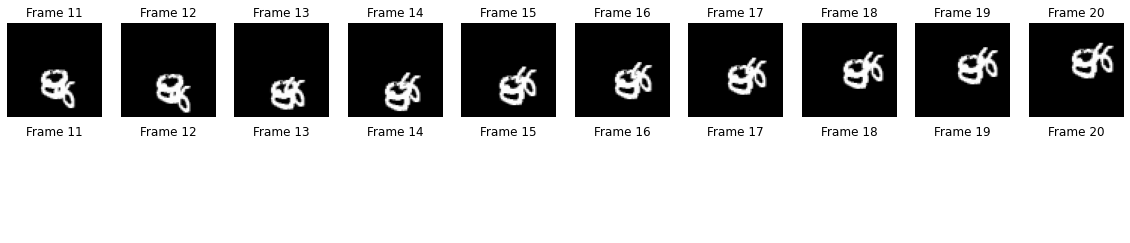

In [9]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

# Predicted Videos

Finally, we'll pick a few examples from the validation set and construct some GIFs with them to see the model's predicted videos.


In [10]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction
